In [2]:
%cd C:\Users\esurujiu\AppData\Local\miniconda3\envs\GOs

import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL  
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from sklearn.decomposition import PCA
import pywt
import calendar
from statsmodels.graphics.tsaplots import month_plot
import scipy.stats as st
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime

C:\Users\esurujiu\AppData\Local\miniconda3\envs\GOs


# Seasonality checks

Here we attempt to model seasonality and see the repeating patterns for the returns behaviour on different scales

## Weakly scale -> no evidance

                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                     1.027
Date:                Tue, 01 Jul 2025   Prob (F-statistic):              0.394
Time:                        13:45:07   Log-Likelihood:                 242.44
No. Observations:                 284   AIC:                            -474.9
Df Residuals:                     279   BIC:                            -456.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0102      0.007     -1.514      0.1

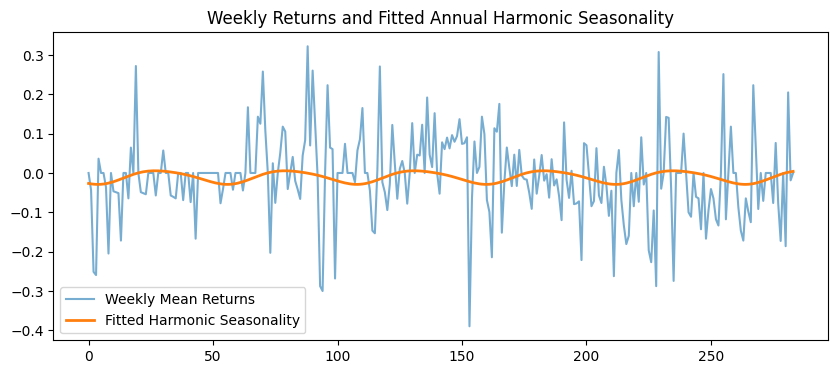

Text(0.5, 0.98, 'STL Decomposition (weekly)')

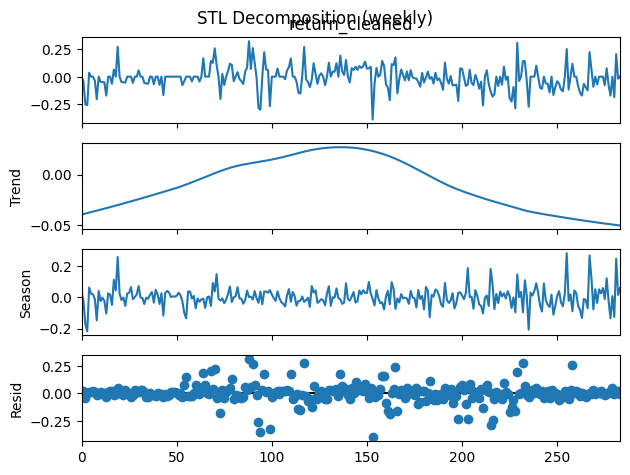

In [3]:
weekly = pd.read_csv('data/01_interim/GO_weekly_price_change.csv')

# 2) Create a time index t = 0,1,2,… for each week
t = np.arange(len(weekly))

# 3) Build your Fourier terms for an annual cycle (≈52 weeks)
#    Here we include the first two harmonics; you can add more if needed.
fourier = pd.DataFrame({
    'sin1':  np.sin(2 * np.pi * t / 52),
    'cos1':  np.cos(2 * np.pi * t / 52),
    'sin2':  np.sin(4 * np.pi * t / 52),
    'cos2':  np.cos(4 * np.pi * t / 52),
}, index=weekly.index)

# 4) Assemble X & y
Xw = sm.add_constant(fourier)
yw = weekly['return_cleaned']

# 5) Fit with HAC(1) SEs to guard against serial correlation
model_w = sm.OLS(yw, Xw).fit(cov_type='HAC', cov_kwds={'maxlags':1})
print(model_w.summary())

# 6) If you want the fitted seasonal curve, predict it:
seasonal_fit = model_w.predict(Xw)

# 7) Plot actual vs. fitted seasonal component
plt.figure(figsize=(10,4))
plt.plot(yw.index, yw,    label='Weekly Mean Returns', alpha=0.6)
plt.plot(yw.index, seasonal_fit, 
         label='Fitted Harmonic Seasonality', linewidth=2)
plt.legend()
plt.title("Weekly Returns and Fitted Annual Harmonic Seasonality")
plt.show()


stl = STL(weekly['return_cleaned'], period=52, robust=True)
res = stl.fit()
fig = res.plot()
fig.suptitle("STL Decomposition (weekly)")

## Monthly scale (NOTE: Clear results, makes sense for compliance)

C:\Users\esurujiu\AppData\Local\Temp\ipykernel_22076\3171041442.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M', on='Modified on')


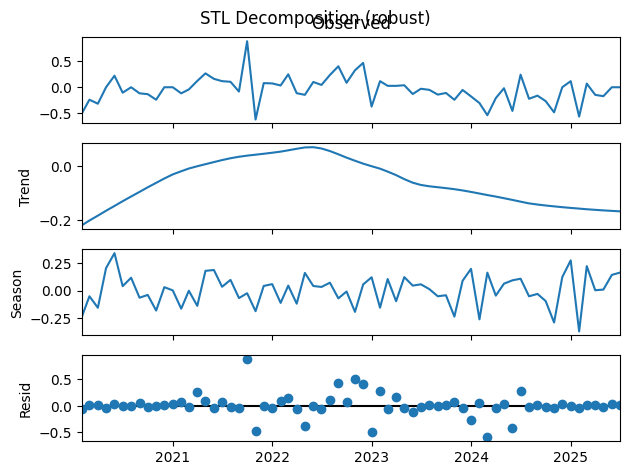

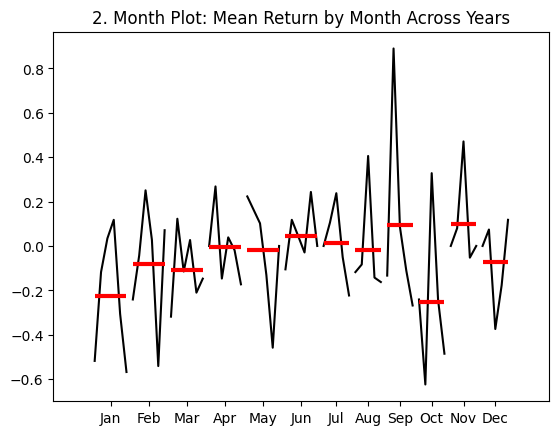

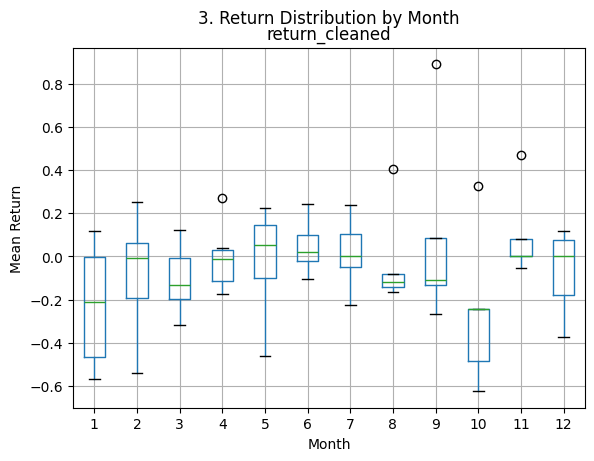

In [10]:
spot = pd.read_csv('data/00_raw/spot.csv')
spot = spot[['Modified on', 'return_cleaned']]
spot['Modified on'] = pd.to_datetime(spot['Modified on'], utc=True)

monthly = (spot
      .resample('M', on='Modified on')
      .sum()                # sum
      .dropna()             # seasonal_decompose won’t accept any NaNs
)

stl = STL(monthly, period=12, robust=True)
res = stl.fit()
fig = res.plot()
fig.suptitle("STL Decomposition (robust)") 


fig, ax = plt.subplots()
month_plot(monthly, ax=ax)
ax.set_title("2. Month Plot: Mean Return by Month Across Years")
plt.show()

monthly['month'] = monthly.index.month
fig, ax = plt.subplots()
monthly.boxplot(column='return_cleaned', by='month', ax=ax)
plt.suptitle("3. Return Distribution by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Mean Return")
plt.show()

monthly.to_csv('data/01_interim/monthly.csv')

In [11]:
# build monthly dummies
dummies = pd.get_dummies(monthly['month'], prefix='m', drop_first=True, dtype=float)
X = sm.add_constant(dummies)         # automatically gets the dfm.index
y = monthly['return_cleaned']

# 4) fit with HAC(1) SEs
model_m = sm.OLS(y, X, missing='drop')\
            .fit(cov_type='HAC', cov_kwds={'maxlags':1})

print(model_m.summary())


                            OLS Regression Results                            
Dep. Variable:         return_cleaned   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.518
Date:                Tue, 01 Jul 2025   Prob (F-statistic):              0.152
Time:                        13:49:38   Log-Likelihood:                 3.1483
No. Observations:                  66   AIC:                             17.70
Df Residuals:                      54   BIC:                             43.98
Df Model:                          11                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2263      0.106     -2.131      0.0

In [13]:
model_nw = model_m.get_robustcov_results(
    cov_type = 'HAC',
    maxlags = 1 
)

model_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         return_cleaned   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.518
Date:                Tue, 01 Jul 2025   Prob (F-statistic):              0.152
Time:                        13:53:17   Log-Likelihood:                 3.1483
No. Observations:                  66   AIC:                             17.70
Df Residuals:                      54   BIC:                             43.98
Df Model:                          11                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2263      0.106     -2.131      0.033      -0.435      -0.018
m_2            0.1470      0.132      1.111      0.267      -0.112       0.406
m_3            0.1193      0.122      0.980      0.327      -0.119       0.358
m_4            0.2210      0.121      1.819      0.069      -0.017       0.459
m_5            0.2094      0.141      1.482      0.138      -0.068       0.486
m_6            0.2716      0.116      2.349      0.019       0.045       0.498
m_7            0.2403      0.127      1.897      0.058      -0.008       0.488
m_8            0.2062      0.143      1.441      0.150      -0.074       0.487
m_9            0.3191      0.214      1.494      0.135      -0.100       0.738
m_10          -0.0267      0.180     -0.148      0.882      -0.380       0.326
m_11           0.3260      0.136      2.395      0.017       0.059       0.593
m_12           0.1545      0.147      1.049      0.294      -0.134       0.443
==============================================================================
Omnibus:                        9.037   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.149
Skew:                           0.686   Prob(JB):                       0.0103
Kurtosis:                       4.201   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""